In [504]:
from food.tools import *
from food.paths import *
from food.psql import *
import numpy as np
import torch
from torch.nn import CosineSimilarity
import requests
from food.qdrant import *
cos = CosineSimilarity(dim=1, eps=1e-08)
import pandas as pd

In [505]:
#export
def search_image(url=None,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [506]:
collection_name = 'food'
table = 'foods'
foods = read_sql(table)
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [533]:
url = 'http://glovo.away.guru/photos_resized/NZTCKFL_0076494_1516096262.png'
image_clip,selected = search_image(url,head=100)

In [543]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

In [548]:
selected = selected.reset_index(drop=True)
for i in reversed(selected.index):
    clip = series2tensor(selected['clip'])
    T = torch.cat([clip[0:i], clip[i+1:]])
    testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
    if testscore > initscore: 
        r = selected.loc[i,'description']
        selected = selected.drop(i)
        initscore = testscore
        # print(f"removed {r}")
    else:
        T = torch.cat([clip, clip[i].reshape(1,768)])
        testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
        if testscore > initscore: 
            selected = selected.append(selected.loc[i])
            # print(f"added {selected.loc[i,'description']}")
            initscore = testscore

    



print(initscore)
count = selected.groupby('description')['clip'].count().sort_index()
r = selected.drop_duplicates('description').set_index("description").sort_index()
r['count'] = count
r.sort_values('count',ascending = False)

tensor([0.2922], dtype=torch.float64)


,id,category,energy,protein,carb,fat,clip,score,count
description,,,,,,,,,
"Fritter, apple",1101153,"Doughnuts, sweet rolls, pastries",381.0,6.46,34.75,24.46,"[0.057608202, 0.031312082, 0.02672885, -0.0110...",0.258467,6
"Apple, raw",1102644,Apples,52.0,0.26,13.81,0.17,"[0.03289434, 0.009451146, 0.04302109, -0.00526...",0.274602,5
"Cobbler, apple",1101144,Cakes and pies,194.0,2.31,36.38,4.95,"[0.03982123, -0.021529237, 0.030978544, -0.001...",0.239396,4
"Turnover or dumpling, apple",1101181,Cakes and pies,348.0,3.64,43.55,18.08,"[0.047357026, 0.0405507, -0.015996952, -0.0136...",0.246986,4
"Apples, baby food, toddler",1102782,Baby food: fruit,50.0,0.19,11.56,0.36,"[0.0003478544, -0.022820584, 0.033641424, 0.00...",0.245114,2
"Crepe, plain",1101513,"Pancakes, waffles, French toast",223.0,8.78,21.73,10.93,"[0.07472039, 0.041357704, -0.0068391925, -0.01...",0.219865,2
"Kohlrabi, raw",1103356,Other vegetables and combinations,27.0,1.70,6.20,0.10,"[0.046535134, -0.025247127, -0.0028286164, -0....",0.205997,2
Nutrition bar (Balance Original Bar),1101259,Nutrition bars,415.0,28.00,48.73,12.00,"[-0.01209534, 0.0036753116, 0.058078367, -0.00...",0.202616,2
"Whole wheat cereal with apples, baby food, dry, instant",1101839,Baby food: cereals,402.0,6.60,83.20,4.80,"[0.017155621, 0.015462028, 0.0072350083, 0.017...",0.214636,2


In [542]:
selected = selected.reset_index(drop=True)
for i in reversed(selected.index):
    clip = series2tensor(selected['clip'])
    T = torch.cat([clip, clip[i].reshape(1,768)])
    testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
    if testscore > initscore: 
        selected = selected.append(selected.loc[i])
        
        # print(f"added {selected.loc[i,'description']}")
        initscore = testscore
    else:

        T = torch.cat([clip[0:i], clip[i+1:]])
        testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
        if testscore > initscore: 
            r = selected.loc[i,'description']
            selected = selected.drop(i)
            initscore = testscore
            # print(f"removed {r}")




print(initscore)
count = selected.groupby('description')['clip'].count().sort_index()
r = selected.drop_duplicates('description').set_index("description").sort_index()
r['count'] = count
r.sort_values('count',ascending = False)

tensor([0.2922], dtype=torch.float64)


,id,category,energy,protein,carb,fat,clip,score,count
description,,,,,,,,,
"Fritter, apple",1101153,"Doughnuts, sweet rolls, pastries",381.0,6.46,34.75,24.46,"[0.057608202, 0.031312082, 0.02672885, -0.0110...",0.258467,6
"Apple, raw",1102644,Apples,52.0,0.26,13.81,0.17,"[0.03289434, 0.009451146, 0.04302109, -0.00526...",0.274602,5
"Cobbler, apple",1101144,Cakes and pies,194.0,2.31,36.38,4.95,"[0.03982123, -0.021529237, 0.030978544, -0.001...",0.239396,4
"Turnover or dumpling, apple",1101181,Cakes and pies,348.0,3.64,43.55,18.08,"[0.047357026, 0.0405507, -0.015996952, -0.0136...",0.246986,4
"Apples, baby food, toddler",1102782,Baby food: fruit,50.0,0.19,11.56,0.36,"[0.0003478544, -0.022820584, 0.033641424, 0.00...",0.245114,2
"Crepe, plain",1101513,"Pancakes, waffles, French toast",223.0,8.78,21.73,10.93,"[0.07472039, 0.041357704, -0.0068391925, -0.01...",0.219865,2
"Kohlrabi, raw",1103356,Other vegetables and combinations,27.0,1.70,6.20,0.10,"[0.046535134, -0.025247127, -0.0028286164, -0....",0.205997,2
Nutrition bar (Balance Original Bar),1101259,Nutrition bars,415.0,28.00,48.73,12.00,"[-0.01209534, 0.0036753116, 0.058078367, -0.00...",0.202616,2
"Whole wheat cereal with apples, baby food, dry, instant",1101839,Baby food: cereals,402.0,6.60,83.20,4.80,"[0.017155621, 0.015462028, 0.0072350083, 0.017...",0.214636,2


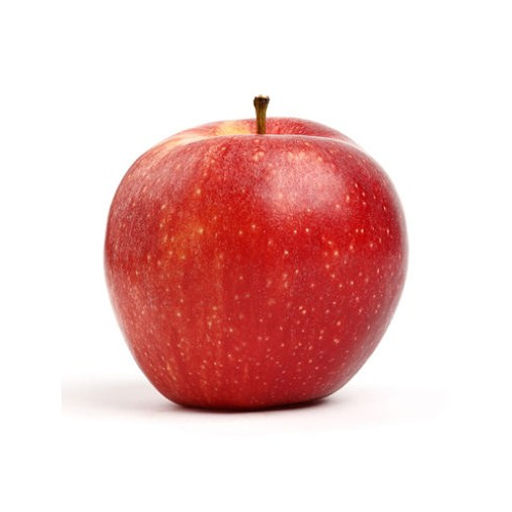

In [549]:
read_image_from_url(url)

In [465]:
selected['energy'].mean()

185.0